In [ ]:
# Denoising Autoencoder on MNIST (PyTorch) — Google Colab-ready
# Author: you :) / minimal educational version

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# -----------------------
# 1) Data: MNIST + subset
# -----------------------
transform = transforms.ToTensor()

train_ds_full = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds_full  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# берем лишь часть (для учебного ноутбука)
train_subset_size = 20000   # можно 5000 / 10000 / 20000
test_subset_size  = 2000

train_ds = Subset(train_ds_full, range(train_subset_size))
test_ds  = Subset(test_ds_full, range(test_subset_size))

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=2, pin_memory=True)




device: cpu


In [ ]:
# -----------------------
# 2) Noise function
# -----------------------
def add_noise(x, noise_std=0.4):
    # x in [0,1], add Gaussian noise and clip back
    noisy = x + noise_std * torch.randn_like(x)
    return torch.clamp(noisy, 0.0, 1.0)

# -----------------------
# 3) Model: simple conv AE
# -----------------------
class DenoisingAE(nn.Module):
    def __init__(self, latent_channels=32):
        super().__init__()
        # Encoder: 1x28x28 -> 32x7x7
        self.enc = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),  # -> 16x14x14
            nn.ReLU(inplace=True),
            nn.Conv2d(16, latent_channels, 3, stride=2, padding=1),  # -> Cx7x7
            nn.ReLU(inplace=True),
        )
        # Decoder: 32x7x7 -> 1x28x28
        self.dec = nn.Sequential(
            nn.ConvTranspose2d(latent_channels, 16, 4, stride=2, padding=1),  # -> 16x14x14
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 1, 4, stride=2, padding=1),  # -> 1x28x28
            nn.Sigmoid(),  # output in [0,1]
        )

    def forward(self, x):
        z = self.enc(x)
        out = self.dec(z)
        return out


In [ ]:

model = DenoisingAE(latent_channels=32).to(device)
print(model)

DenoisingAE(
  (enc): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dec): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): Sigmoid()
  )
)


In [ ]:
# -----------------------
# 4) Train / eval loops
# -----------------------
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [ ]:
@torch.no_grad()
def evaluate(model, loader, noise_std=0.4):
    model.eval()
    total_loss = 0.0
    n = 0
    for x, _ in loader:
        x = x.to(device)
        x_noisy = add_noise(x, noise_std=noise_std)
        x_hat = model(x_noisy)
        loss = criterion(x_hat, x)
        bs = x.size(0)
        total_loss += loss.item() * bs
        n += bs
    return total_loss / n

def train_one_epoch(model, loader, noise_std=0.4):
    model.train()
    total_loss = 0.0
    n = 0
    for x, _ in loader:
        x = x.to(device)
        x_noisy = add_noise(x, noise_std=noise_std)

        optimizer.zero_grad()
        x_hat = model(x_noisy)
        loss = criterion(x_hat, x)
        loss.backward()
        optimizer.step()

        bs = x.size(0)
        total_loss += loss.item() * bs
        n += bs
    return total_loss / n

# -----------------------
# 5) Visualization helper
# -----------------------
@torch.no_grad()
def show_denoising_examples(model, loader, noise_std=0.4, num=8):
    model.eval()
    x, _ = next(iter(loader))
    x = x[:num].to(device)
    x_noisy = add_noise(x, noise_std=noise_std)
    x_hat = model(x_noisy)

    x = x.cpu().numpy()
    x_noisy = x_noisy.cpu().numpy()
    x_hat = x_hat.cpu().numpy()

    plt.figure(figsize=(num*1.6, 4.8))
    for i in range(num):
        # clean
        plt.subplot(3, num, i+1)
        plt.imshow(x[i,0], cmap="gray")
        plt.axis("off")
        if i == 0: plt.ylabel("clean", rotation=0, labelpad=25, va="center")

        # noisy
        plt.subplot(3, num, num+i+1)
        plt.imshow(x_noisy[i,0], cmap="gray")
        plt.axis("off")
        if i == 0: plt.ylabel("noisy", rotation=0, labelpad=25, va="center")

        # recon
        plt.subplot(3, num, 2*num+i+1)
        plt.imshow(x_hat[i,0], cmap="gray")
        plt.axis("off")
        if i == 0: plt.ylabel("recon", rotation=0, labelpad=25, va="center")

    plt.tight_layout()
    plt.show()



Initial test loss: 0.0220767240524292
Epoch 01 | train MSE: 0.01150 | test MSE: 0.01041
Epoch 02 | train MSE: 0.01001 | test MSE: 0.01009
Epoch 03 | train MSE: 0.00980 | test MSE: 0.00991
Epoch 04 | train MSE: 0.00966 | test MSE: 0.00992
Epoch 05 | train MSE: 0.00956 | test MSE: 0.00963
Epoch 06 | train MSE: 0.00949 | test MSE: 0.00957
Epoch 07 | train MSE: 0.00940 | test MSE: 0.00962
Epoch 08 | train MSE: 0.00935 | test MSE: 0.00948
Epoch 09 | train MSE: 0.00931 | test MSE: 0.00935
Epoch 10 | train MSE: 0.00928 | test MSE: 0.00937


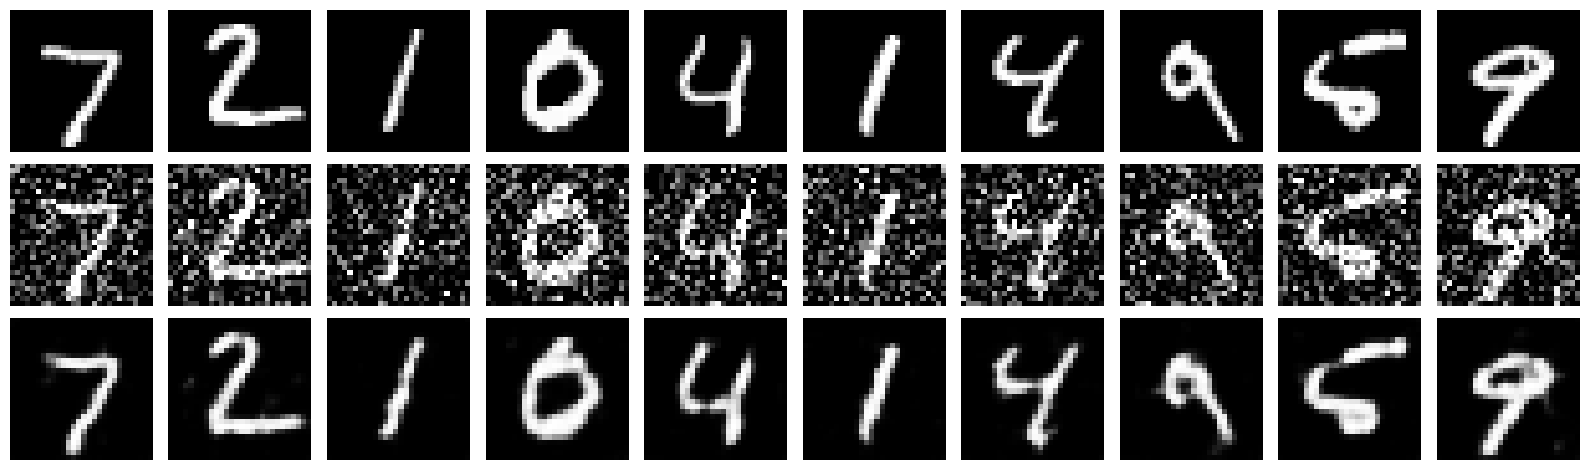

In [ ]:
# -----------------------
# 6) Run training
# -----------------------
noise_std = 0.4
epochs = 10

print("Initial test loss:", evaluate(model, test_loader, noise_std=noise_std))

for epoch in range(1, epochs+1):
    train_loss = train_one_epoch(model, train_loader, noise_std=noise_std)
    test_loss = evaluate(model, test_loader, noise_std=noise_std)
    print(f"Epoch {epoch:02d} | train MSE: {train_loss:.5f} | test MSE: {test_loss:.5f}")

show_denoising_examples(model, test_loader, noise_std=noise_std, num=10)

device: cpu
ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): Sigmoid()
  )
)
Epoch 01: train MSE=0.07448, test MSE=0.01321
Epoch 02: train MSE=0.00692, test MSE=0.00393
Epoch 03: train MSE=0.00296, test MSE=0.00248
Epoch 04: train MSE=0.00212, test MSE=0.00194
Epoch 05: train MSE=0.00173, test MSE=0.00166


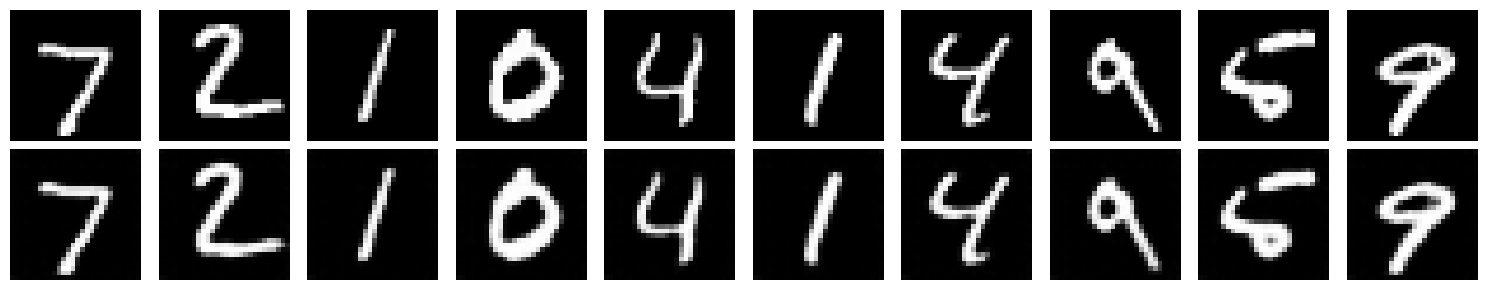

In [ ]:
# Convolutional Autoencoder on MNIST (PyTorch)
# Minimal educational version, Google Colab-ready

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# -----------------------
# 1) Data
# -----------------------
transform = transforms.ToTensor()

train_ds_full = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds_full  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# берём часть датасета
train_ds = Subset(train_ds_full, range(20000))
test_ds  = Subset(test_ds_full, range(2000))

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False)

# -----------------------
# 2) Model: Conv Autoencoder
# -----------------------
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder: 1×28×28 → 32×7×7
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # → 16×14×14
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # → 32×7×7
            nn.ReLU(inplace=True),
        )

        # Decoder: 32×7×7 → 1×28×28
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1), # → 16×14×14
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1),  # → 1×28×28
            nn.Sigmoid()  # т.к. вход в [0,1]
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

model = ConvAutoencoder().to(device)
print(model)

# -----------------------
# 3) Training setup
# -----------------------
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# -----------------------
# 4) Train / Eval loops
# -----------------------
def train_epoch(model, loader):
    model.train()
    total_loss = 0
    for x, _ in loader:
        x = x.to(device)

        optimizer.zero_grad()
        x_hat = model(x)
        loss = criterion(x_hat, x)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)

    return total_loss / len(loader.dataset)

@torch.no_grad()
def eval_epoch(model, loader):
    model.eval()
    total_loss = 0
    for x, _ in loader:
        x = x.to(device)
        x_hat = model(x)
        loss = criterion(x_hat, x)
        total_loss += loss.item() * x.size(0)

    return total_loss / len(loader.dataset)

# -----------------------
# 5) Training
# -----------------------
epochs = 5

for epoch in range(1, epochs + 1):
    train_loss = train_epoch(model, train_loader)
    test_loss = eval_epoch(model, test_loader)
    print(f"Epoch {epoch:02d}: train MSE={train_loss:.5f}, test MSE={test_loss:.5f}")

# -----------------------
# 6) Visualization
# -----------------------
@torch.no_grad()
def show_reconstructions(model, loader, n=10):
    model.eval()
    x, _ = next(iter(loader))
    x = x[:n].to(device)
    x_hat = model(x)

    x = x.cpu()
    x_hat = x_hat.cpu()

    plt.figure(figsize=(n * 1.5, 3))
    for i in range(n):
        plt.subplot(2, n, i + 1)
        plt.imshow(x[i, 0], cmap="gray")
        plt.axis("off")
        if i == 0:
            plt.ylabel("Original", rotation=0, labelpad=30)

        plt.subplot(2, n, n + i + 1)
        plt.imshow(x_hat[i, 0], cmap="gray")
        plt.axis("off")
        if i == 0:
            plt.ylabel("Reconstruction", rotation=0, labelpad=30)

    plt.tight_layout()
    plt.show()

show_reconstructions(model, test_loader)
